# Extreme multi-class classification

ID2223 Scalable Machine Learning and Deep Learning

**Federico Baldassarre (fedbal@kth.se) and Beatrice Ionascu (bionascu@kth.se)**

In [1]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

plt.rcParams['figure.figsize'] = (15, 5)

# add the 'src' directory so we can import modules
sys.path.append('../src')

from utils.paths import data_raw_dir, data_processed_dir

## Problem
The goal of this project is to classify products from [Cdiscount](https://www.cdiscount.com/), France’s largest non-food e-commerce company, based on the product images on the company's website. Being able to correctly predict the category of products is important in ensuring that new products are well classified.

The main challenges are the size of the image dataset, the number of classes and the label imbalance.

## Data set

The Cdiscount dataset consists of 15 million images at 180x180 resolution of almost 9
million products. The training data consists of a list of 7,069,896 dictionaries, one per product. Each dictionary contains a product id, the category id of the product, and between
1-4 images, stored in a list. In addition, each category id has a corresponding level1,
level2, and level3 name, in French.

![data](../figures/data_imgs.png)

In [2]:
categories = pd.read_pickle(os.path.join(data_processed_dir, 'categories.pickle'))
display(HTML(categories.filter(like='category', axis=1).head().to_html(index=False)))

category_id,category_level1,category_level2,category_level3
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


In [3]:
product_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_id_prod_distrib.pickle'))
image_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_id_img_distrib.pickle'))
categ_counts = pd.read_csv(os.path.join(data_raw_dir, 'category_names.csv'))

print('There are {} products'.format(product_distrib.sum()))
print('There are {} images'.format(image_distrib.sum()))
categ_counts.nunique().to_frame('Category counts')

There are 7069896 products
There are 12371293 images


,Category counts
category_id,5270
category_level1,49
category_level2,483
category_level3,5263


The 5270 available categories are very unevenly distributed amongst the products. As shown in the following histograms (one per category level), there are many categories with just a few products and few categories with a very high number of products.

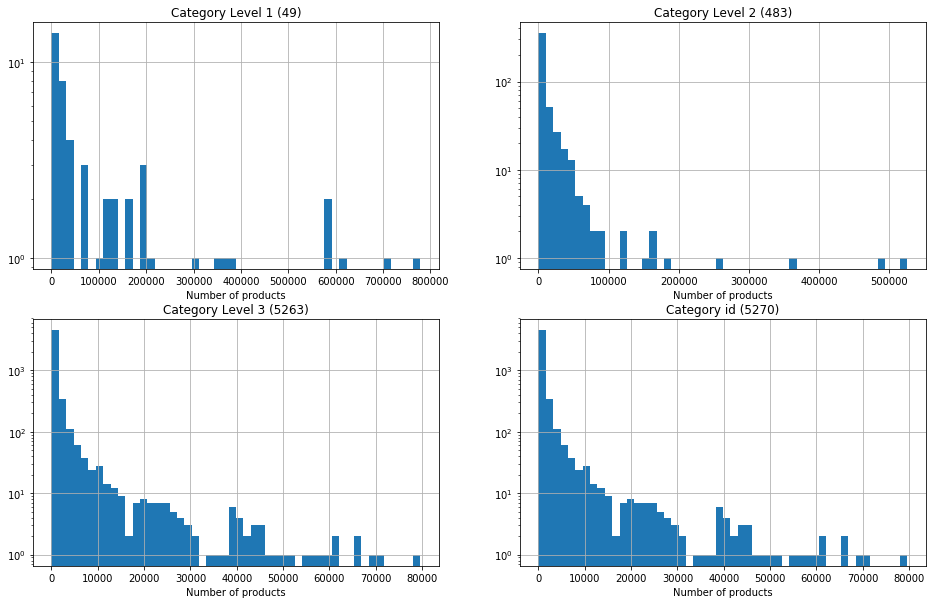

In [4]:
cat_id_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_id_prod_distrib.pickle'))
cat_1_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_1_prod_distrib.pickle'))
cat_2_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_2_prod_distrib.pickle'))
cat_3_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_3_prod_distrib.pickle'))
fig, ax = plt.subplots(2, 2, figsize=(16,10))
ax=ax.ravel()
cat_1_distrib.hist(log=True, bins=50,ax=ax[0])
ax[0].set_title('Category Level 1 ({})'.format(cat_1_distrib.size))
cat_2_distrib.hist(log=True, bins=50,ax=ax[1])
ax[1].set_title('Category Level 2 ({})'.format(cat_2_distrib.size))
cat_3_distrib.hist(log=True, bins=50,ax=ax[2])
ax[2].set_title('Category Level 3 ({})'.format(cat_3_distrib.size))
cat_id_distrib.hist(log=True, bins=50,ax=ax[3])
ax[3].set_title('Category id ({})'.format(cat_id_distrib.size))
for a in ax: a.set_xlabel('Number of products')

The categories with the most and least products are the following:

In [5]:
display(HTML(pd.merge(categories.filter(like='category'), 
         cat_id_distrib.sort_values(ascending=False).head().to_frame('product counts'),
         left_index=True, right_index=True).sort_values('product counts', ascending=False).to_html(index=False)))

display(HTML(pd.merge(categories.filter(like='category'), 
         cat_id_distrib.sort_values(ascending=False).tail().to_frame('product counts'),
         left_index=True, right_index=True).sort_values('product counts', ascending=False).to_html(index=False)))

category_id,category_level1,category_level2,category_level3,product counts
1000018296,MUSIQUE,CD,CD POP ROCK - CD ROCK INDE,79640
1000011423,INFORMATIQUE,IMPRESSION - SCANNER,TONER - RECUPERATEUR DE TONER,71116
1000011427,INFORMATIQUE,IMPRESSION - SCANNER,CARTOUCHE IMPRIMANTE,69784
1000014202,LIBRAIRIE,LITTERATURE,LITTERATURE FRANCAISE,65642
1000015309,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES,65435


category_id,category_level1,category_level2,category_level3,product counts
1000015609,CHAUSSURES - ACCESSOIRES,ACCESSOIRES CHAUSSURES,ESSUIE-BOTTES - LAVE-BOTTES,12
1000013297,ELECTRONIQUE,CAPTEURS,SYSTEME DE SURVEILLANCE DE NIVEAU,12
1000008894,JEUX - JOUETS,JONGLERIE,ASSIETTE CHINOISE,12
1000019804,SPORT,BASEBALL,BLOUSON DE BASEBALL - VESTE DE BASEBALL,12
1000020847,TV - VIDEO - SON,PROTECTION - ENTRETIEN,HOUSSE POUR ENREGISTEUR - HOUSSE POUR DICTAPHO...,12


## Approach
### Transfer Learning
It's been proved, both in the literature and by practical applications, that an image classification task can benefit from transfer learning. They key concept is to reuse the architecture and the weights of another network to extract a representation of the images, which hopefully contains useful information for the classification task. Once an images have been embedded into a compressed feature space, a shallow network can be used to classify them into the final categories.

The skeleton of our network can be sketched as:

![xception+shallow network](../figures/architecture.png)

During training the weights of the feature extraction network are frozen, limiting the weights to train to only those of the shallow network at the end.

The advantages of transfer learning are enabled by the availability of models trained on a very large and general image datasets and released to the public. In fact, training those models can take a long time (up to a few weeks) even in a distributed GPU environment, making it unfeasible to train them jointly with the shallow network at the end. Also, their depth would provide a challenge in terms of gradient propagation, especially at the beginning when the last layers try to classify an image on the base of an embedding that is almost random and therefore are unable to provide the previous layers with useful information on how to update their weights.

We have chosen the recent [Xception model](https://arxiv.org/abs/1610.02357) for feature extraction over the more popular [VGG](https://arxiv.org/abs/1409.1556) or [Inception](https://arxiv.org/abs/1409.4842) models. The choice is motivated by the former being lighter and faster than the other two, achieving almost the same accuracy on the ImageNet benchmark ([comparison](https://keras.io/applications#documentation-for-individual-models)).

### Classification network architecture and negative sampling
The architecture we used for the classification network is composed of three convolutional layers with dropout and a fully connected softmax layer. The purpose of the first 1x1 convolution is to reduce the depth of the embedding volume, before moving further down the network. The output of the final fully connected layer represents the probability distribution over the classes.

```
_________________________________________________________________
Layer (type)                 Output Shape                Param #   
=================================================================
InputLayer                   (?, 6, 6, 2048)                 
_________________________________________________________________
Conv2D (1x1 kernel)          (?, 6, 6, 64)               131,136    
_________________________________________________________________
Dropout                      (?, 6, 6, 64)                   
_________________________________________________________________
Conv2D (4x4 kernel)          (?, 3, 3, 128)              131,200    
_________________________________________________________________
Dropout                      (?, 3, 3, 128)                  
_________________________________________________________________
Conv2D (3x3 kernel)          (?, 1, 1, 256)              295,168    
_________________________________________________________________
Dropout                      (?, 1, 1, 256)                  
________________________________________________________________
Flatten                      (?, 256)                        
_________________________________________________________________
Dense                        (?, 5270)                 1,354,390   
=================================================================
Trainable params: 1,911,894
_________________________________________________________________
```

It is evident that in such architecture the main contribution to the number of trainable parameters comes from the fully connected layer. In fact, it is accountable for approx. 70% of the weights of the network. The reason for this is the high number of probability values to output (5270 versus the 1000 classes of ImageNet). 

Training a network with a large number of parameters turns out to be slow, but we can employ a trick from Natural Language Processing to improve the training speed. Instead of computing the cross entropy loss for all the 5270 output probabilities we can subsample the output vector to include the true label and part of the false labels and only compute the loss for these. In this way we backpropagate fewer gradients through the last layer and reduce the computational effort, effectively speding up training. Of course, the price to pay for subsampling the loss function is less informative gradients and lower final accuracy.

TODO maybe image

## Training

### Pre-processing and feature extraction
Reading and processing the images one by one would prove very slow, due to I/O latency and the heavy computational cost of the Xception model. Therefore, it is better to perform this feature extraction phase prior to training and persist the intermediary embeddings on disk together with the label of the corresponding original image.

Furthermore, to avoid the overhead of continuously switching context between Python and TensorFlow (through `feed_dict`) we employ TFRecord files, a simple record-oriented binary format that can hold several embedding-label pairs. These records can then be read via the TensorFlow-native Dataset API, directly connecting the data to the training pipeline, allowing all the I/O operations to happen inside TensorFlow only.

### Computation graph

This is the computational graph built with the TensorFlow and Keras APIs. The weights of the classification network are at the center of the image, to their left is the training pipeline and to the right the testing pipeline. 

![computation graph](../figures/computational_graph.png)

### Regular loss vs. negative sampled loss

The network was trained with two different loss functions, regular softmax and sampled softmax in order to compare the accuracy and time performance of the two approaches. In both cases we use cross-entropy as loss, except that the sampled version only considers the true label and 1000 negative labels (~20% of all 5270).

### Limitations and distributed training
X% of the 12 million images was used for training and Y% for testing. 

Training experiments were run in parallel on Google Compute Engine instances, with 24 vCPUs and 96 GB of RAM.

## Results

The network was trained for Z epochs, using a batch size of XX. The accuracy and loss metrics are reported per optimization step (not per epoch).

The classification accuracy and loss metrics obtained on the training and tests sets are shown here (0.7 smoothing). 

![results](../figures/metrics_v2.png)

As expected,  
????



## Future work

##### Product-wise classification instead of image-wise
  
In the original setting of the problem, a set of images is given for each unknown product. Our network classifies each image singularly, ideally, a better classification algorithm would exploit all the images to output a single prediction for the product.
  
##### Evaluate the performances on the Kaggle test data

Unfortunately, at the request of the sponsor, the data has been removed post-competition. For this reason, it is not possible to evaluate the performances of the network on the test set used for the competition.

##### More hyperparameter tuning
Having more computing power and time available, we would test the effect of these hyperparameters, both performance-wise and training time-wise:
- Negative sample size (speed/accuracy trade-off)
- Network architecture (number of layers, regularization)

##### Others

Other ways of improving the overall performances are:
- Exploiting the hierarchy of the categories, e.g. first training a network to predict the (fewer) *category_1* labels, then extending it to the other categories
- Extracting text from the images, which would prove extremely useful in the case of books, CDs and similar products, since they represent an important fraction of the dataset (about 10%)